# EuroSAT Satellite Image Analysis using ViT (Vision Transformers and CNNs): Achieving SOTA in Vision Classification

By:- Manav Garg 21BAI1045, Atharva Subhash Bodke 21BAI1855

Installing vit_pytorch released by @lucidrains on Github

In [2]:
pip install vit_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.7/65.7 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.6/117.6 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 2.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


Importing Torch and Changing Device to GPU

In [3]:
import torch

In [4]:
# Check if GPU is available, otherwise fall back to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Dataset Processing

Downloading Data from Google drive using gdown library

In [5]:
pip install gdown

Note: you may need to restart the kernel to use updated packages.


In [6]:
!gdown --id 1OjNzlduSMfSKcuMh6Hrehof61fKyGiLB #EuroSAT
#!gdown --id 18I8Qtj8T1rjlCHVbmA2HEkYAsiNjbMnq # UCMerced

/opt/conda/lib/python3.10/site-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1OjNzlduSMfSKcuMh6Hrehof61fKyGiLB
From (redirected): https://drive.google.com/uc?id=1OjNzlduSMfSKcuMh6Hrehof61fKyGiLB&confirm=t&uuid=d220d9fc-186c-4bae-9bd5-30d3568078b9
To: /kaggle/working/EuroSAT.zip
100%|██████████████████████████████████████| 94.3M/94.3M [00:01<00:00, 51.2MB/s]


## Extracting Data

EuroSAT dataset

In [7]:
import os
import zipfile

def extract_eurosat_zip(zip_file_path, extract_to):
    if not os.path.exists(extract_to):
        os.makedirs(extract_to)

    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        file_list = zip_ref.namelist()
        for file_name in file_list:
            # Extract the file
            zip_ref.extract(file_name, extract_to)
            #print(f"Extracted: {file_name}")

    print("EuroSAT dataset extracted successfully.")



zip_file_path = "/kaggle/working/EuroSAT.zip"
extract_to = "/kaggle/working/EuroSAT/"
extract_eurosat_zip(zip_file_path, extract_to)


EuroSAT dataset extracted successfully.


UC_Merced dataset

In [ ]:
import os
import zipfile

def extract_ucMerced_zip(zip_file_path, extract_to):
    if not os.path.exists(extract_to):
        os.makedirs(extract_to)

    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        file_list = zip_ref.namelist()
        for file_name in file_list:
            # Extract the file
            zip_ref.extract(file_name, extract_to)
            #print(f"Extracted: {file_name}")

    print("UCMerced_LandUse dataset extracted successfully.")



zip_file_path = "/kaggle/working/UCMerced_LandUse.zip"
extract_to = "/kaggle/working/UCMerced_LandUse_extracted/"
extract_ucMerced_zip(zip_file_path, extract_to)


## Loading data into memory. Images + Respective Labels

EuroSAT

In [8]:
import os
from PIL import Image
import numpy as np
import torch

def load_eurosat_dataset(dataset_dir, batch_size=32, device='cuda'):
    class_names = sorted(os.listdir(dataset_dir))
    images = []
    labels = []

    # Iterate over each class folder
    for i, class_name in enumerate(class_names):
        class_dir = os.path.join(dataset_dir, class_name)
        image_names = os.listdir(class_dir)
        num_images = len(image_names)
        num_batches = (num_images + batch_size - 1) // batch_size

        print(f"Loading {num_images} images from class {class_name}...")

        # Iterate over each batch of images
        for batch_idx in range(num_batches):
            batch_image_names = image_names[batch_idx * batch_size : (batch_idx + 1) * batch_size]
            batch_images = []
            batch_labels = []

            # Load and preprocess each image in the batch
            for image_name in batch_image_names:
                image_path = os.path.join(class_dir, image_name)
                try:
                    image = Image.open(image_path)
                    image = image.resize((128, 128))  # Resize image to desired size
                    image = np.array(image) / 255.0  # Normalize pixel values
                    batch_images.append(image)
                    batch_labels.append(i)
                except Exception as e:
                    print(f"Error loading image {image_path}: {e}")

            # Append batch to images and labels lists
            if batch_images:
                images.append(np.array(batch_images))
                labels.append(np.array(batch_labels))
        print(f"Done Loading {num_images} images from class {class_name}...")
    # Concatenate batches into single arrays
    images = np.concatenate(images, axis=0)
    labels = np.concatenate(labels, axis=0)
    images = torch.tensor(np.transpose(images, (0, 3, 1, 2)), dtype=torch.float32).to(device)
    labels = torch.tensor(labels, dtype=torch.long).to(device)
    
    print("==============\nDone loading all images and labels in memory\n==============")

    return images, labels


In [ ]:
import os
from PIL import Image
import numpy as np
import torch

def load_ucmerced_dataset(dataset_dir, batch_size=32):
    class_names = sorted(os.listdir(dataset_dir))
    images = []
    labels = []

    # Iterate over each class folder
    for i, class_name in enumerate(class_names):
        class_dir = os.path.join(dataset_dir, class_name)
        image_names = os.listdir(class_dir)
        num_images = len(image_names)
        num_batches = (num_images + batch_size - 1) // batch_size

        print(f"Loading {num_images} images from class {class_name}...")

        # Iterate over each batch of images
        for batch_idx in range(num_batches):
            batch_image_names = image_names[batch_idx * batch_size : (batch_idx + 1) * batch_size]
            batch_images = []
            batch_labels = []

            # Load and preprocess each image in the batch
            for image_name in batch_image_names:
                image_path = os.path.join(class_dir, image_name)
                try:
                    image = Image.open(image_path)
                    image = image.resize((256, 256)).convert("RGB")  # Resize image to desired size
                    image = np.array(image) / 255.0  # Normalize pixel values
                    batch_images.append(image)
                    batch_labels.append(i)
                except Exception as e:
                    print(f"Error loading image {image_path}: {e}")

            # Append batch to images and labels lists
            if batch_images:
                images.append(np.array(batch_images))
                labels.append(np.array(batch_labels))
        print(f"Done Loading {num_images} images from class {class_name}...")
    # Concatenate batches into single arrays
    images = np.concatenate(images, axis=0)
    labels = np.concatenate(labels, axis=0)
    
    print("==============\nDone loading all images and labels in memory\n==============")

    # Convert images to PyTorch tensor and transpose channels
    images = torch.tensor(np.transpose(images, (0, 3, 1, 2)), dtype=torch.float32).to(device)
    labels = torch.tensor(labels, dtype=torch.long).to(device)

    return images, labels

In [9]:
# Define dataset directory
#dataset_dir = "/kaggle/working/UCMerced_LandUse_extracted/UCMerced_LandUse/Images"

# Define dataset directory
dataset_dir = "/kaggle/working/EuroSAT/2750"

# Load EuroSAT dataset
images, labels = load_eurosat_dataset(dataset_dir)

# Load ucmerced_datasetA
#images, labels = load_ucmerced_dataset(dataset_dir)

Loading 3000 images from class AnnualCrop...
Done Loading 3000 images from class AnnualCrop...
Loading 3000 images from class Forest...
Done Loading 3000 images from class Forest...
Loading 3000 images from class HerbaceousVegetation...
Done Loading 3000 images from class HerbaceousVegetation...
Loading 2500 images from class Highway...
Done Loading 2500 images from class Highway...
Loading 2500 images from class Industrial...
Done Loading 2500 images from class Industrial...
Loading 2000 images from class Pasture...
Done Loading 2000 images from class Pasture...
Loading 2500 images from class PermanentCrop...
Done Loading 2500 images from class PermanentCrop...
Loading 3000 images from class Residential...
Done Loading 3000 images from class Residential...
Loading 2500 images from class River...
Done Loading 2500 images from class River...
Loading 3000 images from class SeaLake...
Done Loading 3000 images from class SeaLake...
Done loading all images and labels in memory


# Importing Libraries and installing vit_pytorch (Vision Transformer Library by lucidrains)

In [10]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageNet
from torchvision.transforms import transforms
from torch.optim.lr_scheduler import StepLR
from vit_pytorch.cct import CCT
from vit_pytorch import ViT
from torch.utils.data import Dataset, DataLoader

In [ ]:
class UC_landUse(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [11]:
class EuroSATDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [12]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((128, 128)), 
    transforms.Lambda(lambda x: x[:3]),  # Keep only the first 3 channels
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [13]:
# Create EuroSAT dataset instance
eurosat_dataset = EuroSATDataset(images, labels)

In [ ]:
# Create UC dataset instance
landUse_Dataset = UC_landUse(images, labels)

In [14]:
from torch.utils.data import random_split

# Define the sizes of training, validation, and test sets
train_size = int(0.8 * len(eurosat_dataset))
val_size = int(0.1 * len(eurosat_dataset))
test_size = len(eurosat_dataset) - train_size - val_size

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(eurosat_dataset, [train_size, val_size, test_size])

# Create data loaders for each split
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [ ]:
from torch.utils.data import random_split

# Define the sizes of training, validation, and test sets
train_size = int(0.8 * len(landUse_Dataset))
val_size = int(0.1 * len(landUse_Dataset))
test_size = len(landUse_Dataset) - train_size - val_size

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(landUse_Dataset, [train_size, val_size, test_size])

# Create data loaders for each split
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [15]:
cct = CCT(
    img_size=(128, 128),
    embedding_dim=384,
    n_conv_layers=13,
    kernel_size=3,
    stride=1,
    padding=2,
    pooling_kernel_size=2,
    pooling_stride=2,
    pooling_padding=0,
    num_layers=14,
    num_heads=6,
    mlp_ratio=5.,
    num_classes=10,
    positional_embedding='learnable'
).to(device)

In [16]:
v = ViT(
    image_size = 128,
    channels = 3,
    patch_size = 32,
    num_classes = 10,
    dim = 1024,
    depth = 6,
    heads = 16,
    mlp_dim = 2048,
    dropout = 0.1,
    emb_dropout = 0.1
).to(device)

In [17]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(v.parameters(), lr=0.0001)

In [18]:
# Define loss function and optimizer
criterion_cct = nn.CrossEntropyLoss()
optimizer_cct = optim.Adam(cct.parameters(), lr=0.001)

# Training Loop

In [19]:
from tqdm import tqdm

In [20]:
num_epochs = 15

### CCT - Compact Transformers

In [22]:
# Training loop
cct.train()  # Set model to training mode
for epoch in range(num_epochs):
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    for images, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', leave=False):
        optimizer.zero_grad()  # Clear gradients
        outputs = cct(images)  # Forward pass
        loss1 = criterion_cct(outputs, labels)  # Compute loss 1
        #loss2 = criterion2(nn.functional.log_softmax(outputs, dim=1).float(), labels)  # Compute loss 2
        total_loss = loss1 
        total_loss.backward()  # Backpropagation
        optimizer_cct.step()  # Update model parameters
        running_loss += total_loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct_predictions / total_predictions
    print(f'Training: Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy * 100:.2f}%')

Training: Epoch 1/15, Loss: nan, Accuracy: 10.99%


Training: Epoch 2/15, Loss: nan, Accuracy: 11.16%


Training: Epoch 3/15, Loss: nan, Accuracy: 11.16%


Training: Epoch 4/15, Loss: nan, Accuracy: 11.16%


Training: Epoch 5/15, Loss: nan, Accuracy: 11.16%


Training: Epoch 6/15, Loss: nan, Accuracy: 11.16%


Training: Epoch 7/15, Loss: nan, Accuracy: 11.16%


Training: Epoch 8/15, Loss: nan, Accuracy: 11.16%


Training: Epoch 9/15, Loss: nan, Accuracy: 11.16%


Training: Epoch 10/15, Loss: nan, Accuracy: 11.16%


KeyboardInterrupt: 

## Base ViT

In [21]:
    # Training loop
    for epoch in range(num_epochs):
        v.train() # Set model to training mode
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0
        for images, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', leave=False):
            optimizer.zero_grad()  # Clear gradients
            outputs = v(images)  # Forward pass
            loss1 = criterion(outputs, labels)  # Compute loss 1
            #loss2 = criterion2(nn.functional.log_softmax(outputs, dim=1).float(), labels)  # Compute loss 2
            total_loss = loss1 
            total_loss.backward()  # Backpropagation
            optimizer.step()  # Update model parameters
            running_loss += total_loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)
        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = correct_predictions / total_predictions
        print(f'Training: Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy * 100:.2f}%')

Training: Epoch 1/15, Loss: 1.2270, Accuracy: 54.69%


Training: Epoch 2/15, Loss: 0.8677, Accuracy: 68.79%


Training: Epoch 3/15, Loss: 0.7002, Accuracy: 75.00%


Training: Epoch 4/15, Loss: 0.5978, Accuracy: 78.54%


Training: Epoch 5/15, Loss: 0.5278, Accuracy: 81.43%


Training: Epoch 6/15, Loss: 0.4660, Accuracy: 83.35%


Training: Epoch 7/15, Loss: 0.4216, Accuracy: 84.83%


Training: Epoch 8/15, Loss: 0.3895, Accuracy: 86.19%


Training: Epoch 9/15, Loss: 0.3595, Accuracy: 87.09%


Training: Epoch 10/15, Loss: 0.3185, Accuracy: 88.61%


Training: Epoch 11/15, Loss: 0.3075, Accuracy: 88.92%


Training: Epoch 12/15, Loss: 0.2982, Accuracy: 89.19%


KeyboardInterrupt: 

# Validation Loop

### CCT Validation

In [24]:
# Validation loop
cct.eval()  # Set model to evaluation mode
val_loss = 0.0
val_correct_predictions = 0
val_total_predictions = 0
with torch.no_grad():
    for images, labels in val_loader:
        outputs = cct(images)
        loss1 = criterion(outputs, labels)  # Compute loss 1]
        total_loss = loss1
        val_loss += total_loss.item()
        _, predicted = torch.max(outputs, 1)
        val_correct_predictions += (predicted == labels).sum().item()
        val_total_predictions += labels.size(0)
    val_loss /= len(val_loader)
    val_accuracy = val_correct_predictions / val_total_predictions
    print(f'Validation: Epoch {epoch + 1}/{num_epochs}, Loss: {val_loss:.4f}, Accuracy: {val_accuracy * 100:.2f}%')

Validation: Epoch 15/15, Loss: nan, Accuracy: 10.04%


### Base ViT Validation

In [ ]:
# Validation loop
v.eval()  # Set model to evaluation mode
val_loss = 0.0
val_correct_predictions = 0
val_total_predictions = 0
with torch.no_grad():
    for images, labels in val_loader:
        outputs = v(images)
        loss1 = criterion(outputs, labels)  # Compute loss 1
        total_loss = loss1
        val_loss += total_loss.item()
        _, predicted = torch.max(outputs, 1)
        val_correct_predictions += (predicted == labels).sum().item()
        val_total_predictions += labels.size(0)
    val_loss /= len(val_loader)
    val_accuracy = val_correct_predictions / val_total_predictions
    print(f'Validation: Epoch {epoch + 1}/{num_epochs}, Loss: {val_loss:.4f}, Accuracy: {val_accuracy * 100:.2f}%')

# Testing Loop

### Base ViT Testing

In [23]:
# Lists to store test loss and accuracy
test_loss_history = []
test_accuracy_history = []

# Lists to store predictions and ground truths
predictions = []
true_labels = []

# Testing loop
v.eval()  # Set model to evaluation mode
test_running_loss = 0.0
correct = 0
total = 0
with torch.no_grad():  # Disable gradient calculation
    for images, labels in tqdm(test_loader, desc='Testing', leave=False):
        outputs = v(images)  # Forward pass
        predicted_labels = torch.argmax(outputs, dim=1)
        predictions.extend(predicted_labels.tolist())
        true_labels.extend(labels.tolist())
        loss1 = criterion(outputs, labels)  # Compute loss 1
        total_loss = loss1
        test_running_loss += total_loss.item()
        _, predicted = torch.max(outputs, 1)  # Get predicted labels
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    # Calculate test loss and accuracy for the current epoch
    test_loss = test_running_loss / len(test_loader)
    test_accuracy = 100 * correct / total

    # Record test loss and accuracy
    test_loss_history.append(test_loss)
    test_accuracy_history.append(test_accuracy)

# Print test loss, accuracy, correct predictions, and total predictions
print(f'Test Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.2f}%, Correct Predictions: {correct}, Total Predictions: {total}')


Test Loss: 0.7318, Accuracy: 78.48%, Correct Predictions: 2119, Total Predictions: 2700


### CCT Testing

In [27]:
# Testing loop
cct.eval()  # Set model to evaluation mode
test_running_loss = 0.0
correct = 0
total = 0
with torch.no_grad():  # Disable gradient calculation
    for images, labels in tqdm(test_loader, desc='Testing', leave=False):
        outputs = cct(images)  # Forward pass
        loss1 = criterion(outputs, labels)  # Compute loss 1
        total_loss = loss1
        test_running_loss += total_loss.item()
        _, predicted = torch.max(outputs, 1)  # Get predicted labels
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate and print average loss and accuracy
test_loss = test_running_loss / len(test_loader)
test_accuracy = 100 * correct / total

print(f'Test Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.2f}%, Correct Predictions: {correct}, Total Predictions: {total}')

Test Loss: nan, Accuracy: 11.81%, Correct Predictions: 319, Total Predictions: 2700


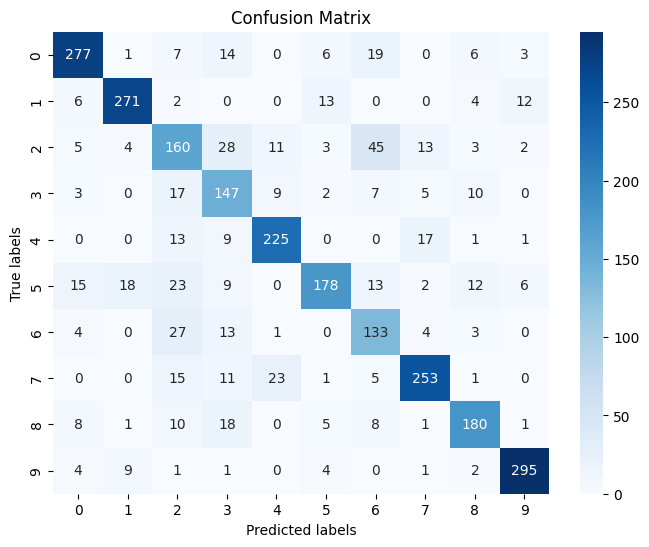

In [29]:
import torchmetrics
import seaborn as sns
import matplotlib.pyplot as plt

# Convert true labels and predictions to tensors
true_labels_tensor = torch.tensor(true_labels)
predictions_tensor = torch.tensor(predictions)

# Compute the confusion matrix
conf_matrix = torchmetrics.functional.confusion_matrix(true_labels_tensor, predictions_tensor, num_classes=10, task='MULTICLASS', normalize=None)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()